# Rate my prof feature selection analysis

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [254]:
reviews_df = pd.read_csv('all_reviews.csv')

print(len(reviews_df))
print(reviews_df.columns)

takenForCredit_Values = reviews_df['takenForCredit'].value_counts()
print("taken for credit:",takenForCredit_Values, reviews_df['takenForCredit'].isnull().sum(), "\n")

onlineClass_Values = reviews_df['onlineClass'].value_counts()
print("online class:", onlineClass_Values, reviews_df['onlineClass'].isnull().sum(), "\n")

attendance_Values = reviews_df['attendance'].value_counts()
print("attendance:", attendance_Values, reviews_df['attendance'].isnull().sum(), "\n")

wouldTakeAgain_Values = reviews_df['rWouldTakeAgain'].value_counts()
print("would take again:", wouldTakeAgain_Values, reviews_df['rWouldTakeAgain'].isnull().sum(), "\n")

63951
Index(['teacher_id', 'attendance', 'clarityColor', 'easyColor', 'helpColor',
       'helpCount', 'id', 'notHelpCount', 'onlineClass', 'quality', 'rClarity',
       'rClass', 'rComments', 'rDate', 'rEasy', 'rEasyString', 'rErrorMsg',
       'rHelpful', 'rInterest', 'rOverall', 'rOverallString', 'rStatus',
       'rTextBookUse', 'rTimestamp', 'rWouldTakeAgain', 'sId',
       'takenForCredit', 'teacher', 'teacherGrade', 'teacherRatingTags',
       'unUsefulGrouping', 'usefulGrouping', 'overall_rating'],
      dtype='object')
taken for credit: Yes    32840
No      1394
Name: takenForCredit, dtype: int64 29717 

online class: online    6755
Name: onlineClass, dtype: int64 57196 

attendance: Mandatory        17498
Not Mandatory    13846
Name: attendance, dtype: int64 32607 

would take again: Yes    18360
No      9084
Name: rWouldTakeAgain, dtype: int64 36507 



## 1. Cleaning the data

In [255]:
# define the features to be used for the model
cleaning_features = np.array(['onlineClass',
'rEasy', 'rWouldTakeAgain', 'teacherGrade', 'rClarity', 'rInterest', 'takenForCredit', 'attendance'])

print(reviews_df.isnull().sum())
print('before:', len(reviews_df))

# could use reviews comments to predict rInterest
reviews_df = reviews_df.dropna(subset=['teacherGrade', 'rInterest'])
print('after:', len(reviews_df), "\n")

# print the number of null values and the number of unique values for each feature 
def print_values_and_null_values(df, feature):
    print(df[feature].value_counts())
    print(df[feature].isnull().sum())

print_values_and_null_values(reviews_df, ['takenForCredit', 'onlineClass', 'attendance', 'rWouldTakeAgain'])
print("\n")

reviews_df['onlineClass'] = reviews_df['onlineClass'].fillna('In person') # safe assumption

# mapping the columns to numerical values
# NOTE: it is important to start at 1 and not 0 because 0 will work with the weighted average
grades = {'A+': 12, 'A': 11, 'A-': 10, 'B+': 9, 'B': 8, 'B-': 7.5, 'C+': 7, 'C': 6, 'C-': 5.5, 'D+': 5, 'D': 4, 'P': 5, 'D-': 3.5, 'E':3, 'F': 2, 'Not sure yet': 1, 'WD': 1, 'INC': 1, 'Audit/No Grade': 1}
interests = {"It's my life": 5, 'Really into it': 4, 'Sorta interested': 3, 'Low': 2, 'Meh': 1}
attendances = {'Mandatory': 2, 'Not Mandatory': 1}
wouldTakeAgain = {'Yes': 2, 'No': 1}
takenForCredit = {'Yes': 2, 'No': 1}
onlineClass = {'In person': 2, 'online': 1}

def map_values(df, feature, mapping):
    df[feature] = df[feature].map(mapping)

map_values(reviews_df, 'teacherGrade', grades)
map_values(reviews_df, 'rInterest', interests)
map_values(reviews_df, 'attendance', attendances)
map_values(reviews_df, 'rWouldTakeAgain', wouldTakeAgain)
map_values(reviews_df, 'takenForCredit', takenForCredit)
map_values(reviews_df, 'onlineClass', onlineClass)

# interpolates missing values with nearest values
def interpolate_missing_values(df, feature):
    df[feature] = df[feature].interpolate(method="nearest").ffill().bfill()

interpolate_missing_values(reviews_df, 'attendance')
interpolate_missing_values(reviews_df, 'rWouldTakeAgain')
interpolate_missing_values(reviews_df, 'takenForCredit')

print_values_and_null_values(reviews_df, ['takenForCredit', 'onlineClass', 'attendance', 'rWouldTakeAgain'])
print("\n")

cleaned_reviews_df = pd.DataFrame()

def calculate_weighted_average(df, feature):
    return np.average(df[feature], weights=df['ratingHelpfulness'])

for teacher_id in reviews_df['teacher_id'].unique():
    teacher_reviews = reviews_df[reviews_df['teacher_id'] == teacher_id]

    # calculate the weighted of every review
    teacher_reviews['ratingHelpfulness'] = teacher_reviews['helpCount'] - teacher_reviews['notHelpCount']
    teacher_reviews['ratingHelpfulness'] = teacher_reviews['ratingHelpfulness'] + abs(teacher_reviews['ratingHelpfulness'].min()) + 1
    teacher_reviews['ratingHelpfulness'] = teacher_reviews['ratingHelpfulness'] / teacher_reviews['ratingHelpfulness'].max()

    # apply the weighted average to the columns
    average_attendance = calculate_weighted_average(teacher_reviews, "attendance")
    average_onlineClass = calculate_weighted_average(teacher_reviews, "onlineClass")
    average_rEasy = calculate_weighted_average(teacher_reviews, "rEasy")
    average_rWouldTakeAgain = calculate_weighted_average(teacher_reviews, "rWouldTakeAgain")
    average_teacherGrade = calculate_weighted_average(teacher_reviews, "teacherGrade")
    average_rClarity = calculate_weighted_average(teacher_reviews, "rClarity")
    average_rInterest = calculate_weighted_average(teacher_reviews, "rInterest")
    average_takenForCredit = calculate_weighted_average(teacher_reviews, "takenForCredit")
    average_overall_rating = calculate_weighted_average(teacher_reviews, "rOverall")

    # append the new row to the dataframe
    cleaned_reviews_df = cleaned_reviews_df.append({'teacher_id': teacher_id, 'overall_rating': average_overall_rating, 'attendance': average_attendance, 'onlineClass': average_onlineClass, 'rEasy': average_rEasy, 'rWouldTakeAgain': average_rWouldTakeAgain, 'teacherGrade': average_teacherGrade, 'rClarity': average_rClarity, 'rInterest': average_rInterest, 'takenForCredit': average_takenForCredit}, ignore_index=True)

# create a new CSV file with the weighted averages
cleaned_reviews_df.to_csv('cleaned_reviews.csv', index=False)

teacher_id               0
attendance           32607
clarityColor             0
easyColor                0
helpColor                0
helpCount                0
id                       0
notHelpCount             0
onlineClass          57196
quality                  0
rClarity                 0
rClass                   4
rComments                0
rDate                    0
rEasy                    0
rEasyString              0
rErrorMsg            63951
rHelpful                 0
rInterest            32254
rOverall                 0
rOverallString           0
rStatus                  0
rTextBookUse         10834
rTimestamp               0
rWouldTakeAgain      36507
sId                      0
takenForCredit       29717
teacher              63951
teacherGrade         40082
teacherRatingTags        0
unUsefulGrouping         0
usefulGrouping           0
overall_rating          49
dtype: int64
before: 63951
after: 4695 

takenForCredit  onlineClass  attendance     rWouldTakeAgain
Yes     

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## 1.1 Doing one hot encoding on teacher rating tags

In [256]:
# one-hot encoding

# do one hot encoding for teacherRatingTags column
reviews_df['teacherRatingTags'] = reviews_df['teacherRatingTags'].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.strip().str.split(', ')
reviews_df = reviews_df.join(pd.get_dummies(reviews_df['teacherRatingTags'].apply(pd.Series).stack()).sum(level=0))
print(reviews_df.columns)

features = np.array(['attendance', 'onlineClass',
'rEasy', 'rWouldTakeAgain', 'teacherGrade', 'quality', 'rClarity', 'rInterest', 'takenForCredit', 'Amazing lectures', 'Amazing lectures ',
'Beware of pop quizzes', 'Caring', 'Clear grading criteria',
'EXTRA CREDIT', 'Get ready to read', 'Gives good feedback',
'Group projects', 'Hilarious', 'Inspirational', 'Lecture heavy',
'Lots of homework', 'Participation matters', 'Respected',
'So many papers', 'Tough grader'])

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


Index(['teacher_id', 'attendance', 'clarityColor', 'easyColor', 'helpColor',
       'helpCount', 'id', 'notHelpCount', 'onlineClass', 'quality', 'rClarity',
       'rClass', 'rComments', 'rDate', 'rEasy', 'rEasyString', 'rErrorMsg',
       'rHelpful', 'rInterest', 'rOverall', 'rOverallString', 'rStatus',
       'rTextBookUse', 'rTimestamp', 'rWouldTakeAgain', 'sId',
       'takenForCredit', 'teacher', 'teacherGrade', 'teacherRatingTags',
       'unUsefulGrouping', 'usefulGrouping', 'overall_rating', '',
       'Amazing lectures', 'Amazing lectures ', 'Beware of pop quizzes',
       'Caring', 'Clear grading criteria', 'EXTRA CREDIT', 'Get ready to read',
       'Gives good feedback', 'Group projects', 'Hilarious', 'Inspirational',
       'Lecture heavy', 'Lots of homework', 'Participation matters',
       'Respected', 'So many papers', 'Tough grader'],
      dtype='object')


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """


## 2. PCA

teacher_id         0
overall_rating     0
attendance         0
onlineClass        0
rEasy              0
rWouldTakeAgain    0
teacherGrade       0
rClarity           0
rInterest          0
takenForCredit     0
dtype: int64
1255


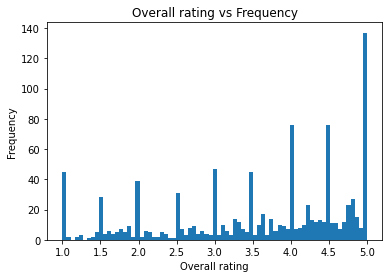

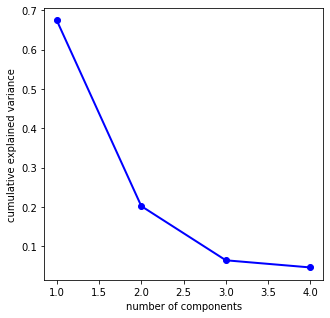

In [257]:
# print all columns with null values
from sklearn.preprocessing import MinMaxScaler


print(cleaned_reviews_df.isnull().sum())
print(len(cleaned_reviews_df))

k = 4 #len(cleaning_features)
x = cleaned_reviews_df[cleaning_features]
y = cleaned_reviews_df['overall_rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

plt.hist(y_train, bins=75)
plt.xlabel('Overall rating')
plt.ylabel('Frequency')
plt.title('Overall rating vs Frequency')
plt.show()

# use min max scaler to scale the data
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# do PCA
pca = PCA(n_components=k).fit(x_train)
z_train = pca.transform(x_train)
z_test = pca.transform(x_test)

# make scree plot
plt.plot(np.arange(k) + 1, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.gcf().set_size_inches(5, 5)
plt.show()

## 3. Predictions and feature selection

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


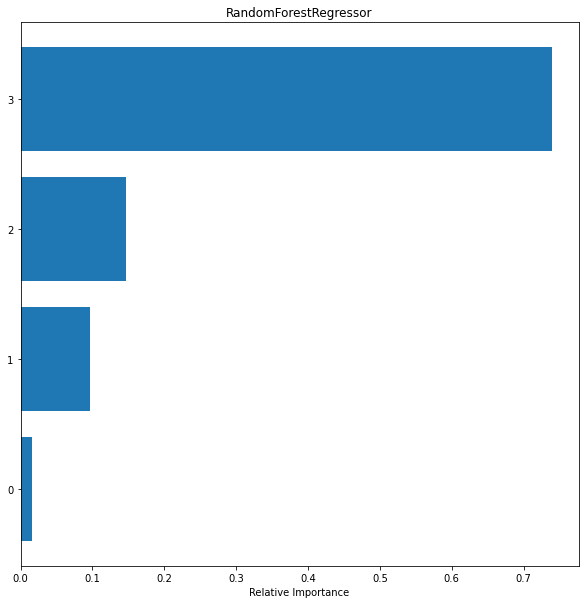

[0.14703811 0.73961165 0.01638513 0.09696511]
RandomForestRegressor :  0.8942696433299829


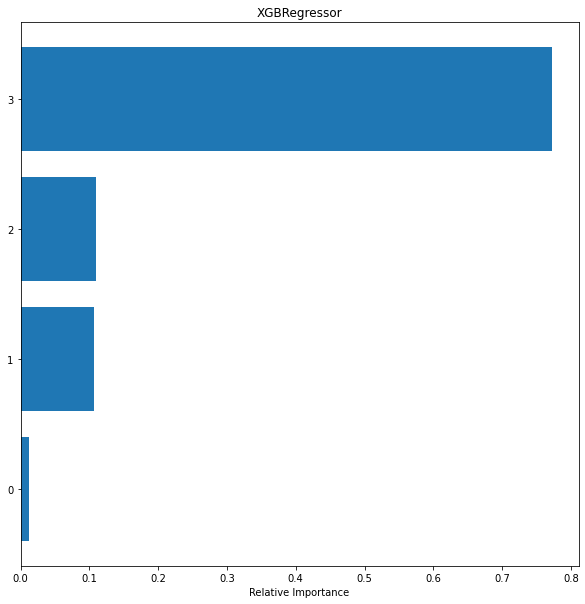

[0.10603832 0.77250296 0.01185902 0.10959973]
XGBRegressor :  0.8819273405574992


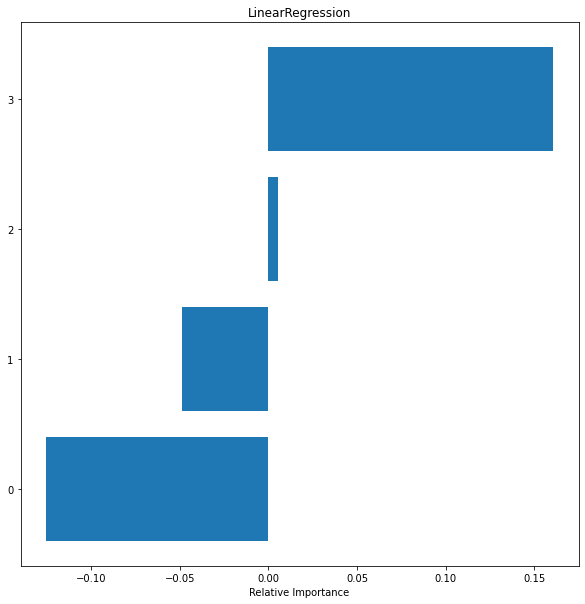

[-0.04889736  0.16056632  0.00523776 -0.1254395 ]
LinearRegression :  0.9227292292831633


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.04889736  0.16056632  0.00523776 -0.1254395 ]
MLPRegressor :  0.9053683634800023


In [265]:
def runModels(x_train, y_train, x_test, y_test, withPCA):
    models = [RandomForestRegressor(), XGBRegressor(), LinearRegression(), MLPRegressor()]
    for model in models:
        model.fit(x_train, y_train)

        model_name = str(model).split('(')[0]

        if(model_name != "LinearRegression" and model_name != "MLPRegressor"):
            feature_importances = model.feature_importances_
            feature_sorted = np.argsort(feature_importances)

            plt.figure(figsize=(10, 10))
            plt.title(str(model).split('(')[0])
            plt.barh(range(len(feature_sorted)), feature_importances[feature_sorted], align='center')
            if(withPCA):
                plt.yticks(range(len(feature_sorted)))
            else:
                plt.yticks(range(len(feature_sorted)), cleaning_features[feature_sorted])
            plt.xlabel('Relative Importance')
            plt.show()
        elif (model_name == "LinearRegression"):
            # print coefficients
            feature_importances = model.coef_[0]
            feature_sorted = np.argsort(feature_importances)

            plt.figure(figsize=(10, 10))
            plt.title(str(model).split('(')[0])
            plt.barh(range(len(feature_sorted)), feature_importances[feature_sorted], align='center')
            if (withPCA):
                plt.yticks(range(len(feature_sorted)))
            else:
                plt.yticks(range(len(feature_sorted)), cleaning_features[feature_sorted])
            plt.xlabel('Relative Importance')
            plt.show()

        print(feature_importances)

        print(model_name, ": ", model.score(x_test, y_test))

runModels(z_train, y_train_scaled, z_test, y_test_scaled, True)

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


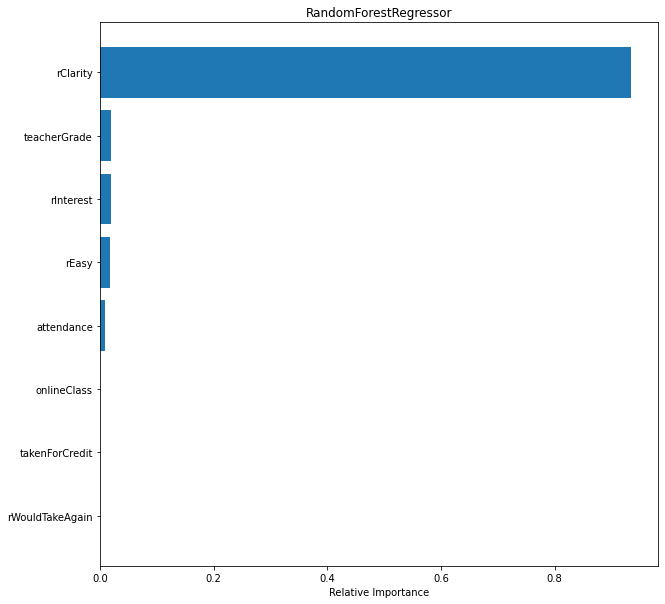

[5.99149958e-04 1.72431182e-02 0.00000000e+00 1.99369354e-02
 9.34951440e-01 1.88680733e-02 3.72278124e-05 8.36405574e-03]
RandomForestRegressor :  0.9122616735427486


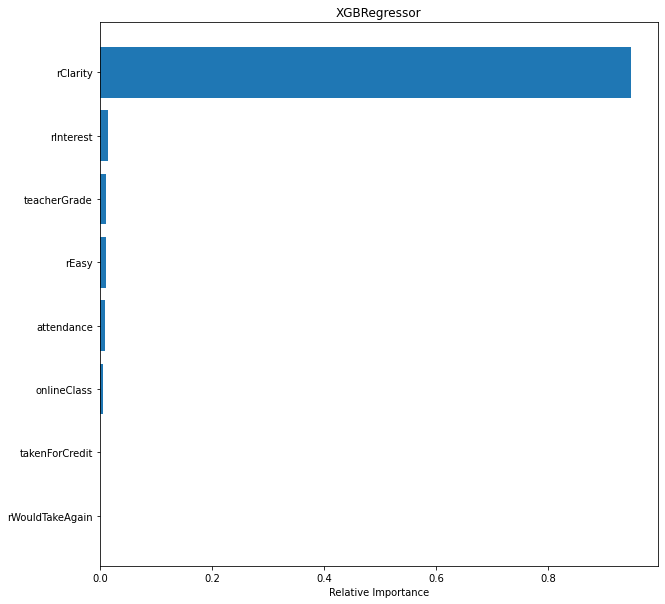

[5.7496862e-03 1.0144626e-02 0.0000000e+00 1.0583142e-02 9.4838619e-01
 1.4545530e-02 8.2431431e-04 9.7665032e-03]
XGBRegressor :  0.8927684101751006


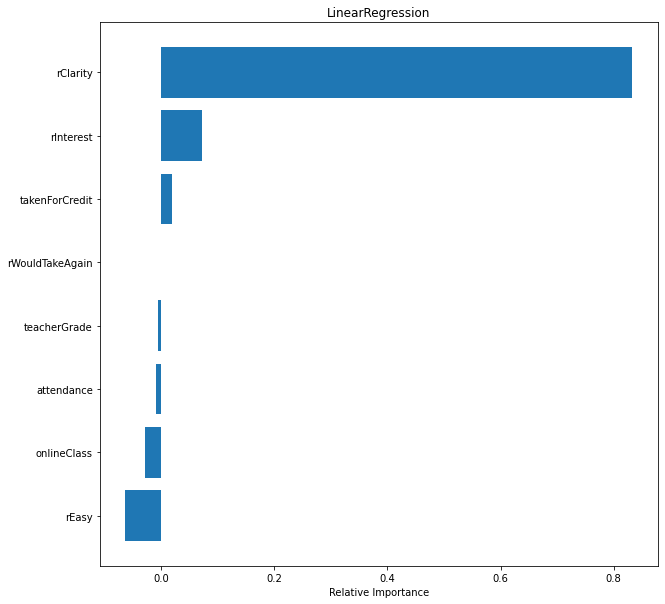

[-0.02826053 -0.06382107  0.         -0.00501528  0.83316399  0.07278801
  0.01979716 -0.01011566]
LinearRegression :  0.9200684600049441


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.02826053 -0.06382107  0.         -0.00501528  0.83316399  0.07278801
  0.01979716 -0.01011566]
MLPRegressor :  0.8945133902269063


In [269]:
# without PCA to get feature importances

# normalize the data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))


runModels(x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, False)

## 4. Corrolation matrix 

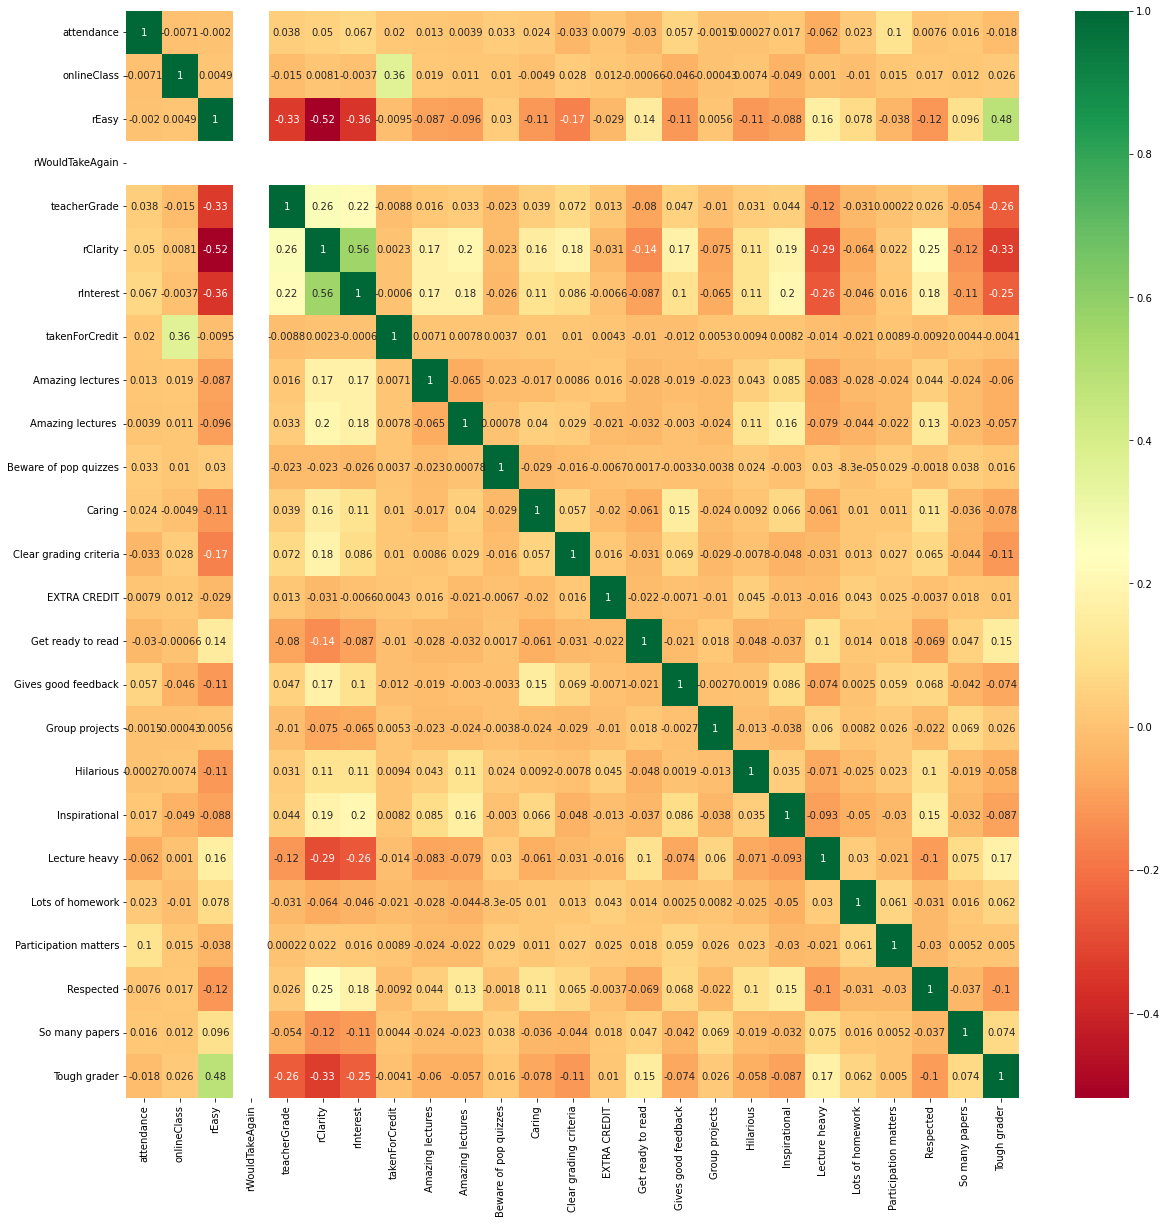

In [ ]:
corr_matrix = reviews_df[features].corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(20,20))
g=sns.heatmap(reviews_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Notes:
- The best model is the one with the highest accuracy score.
- There may be overfitting in the models.
- In the future, we could add the teacher rating tags
- To better predict the interest level, we could use the description of the reviews and use NLP to extract the features.